In [1]:
import sys
import os

import xarray as xr

import cf_xarray as cfxr
import xesmf as xe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pyproj
import pyresample
from pyresample import create_area_def, load_area, data_reduce, utils, AreaDefinition
from pyresample.geometry import SwathDefinition, GridDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss 
from pyresample.bilinear import XArrayBilinearResampler #NumpyBilinearResampler #

from sklearn import svm
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline


%matplotlib inline
#%matplotlib notebook

In [2]:
#sys.path.append('/home/mario/Documents/Coursera\
#/Unsupervised/week1/Labs/Lab2/Files/home/jovyan/work')
#from utils import *
print(pyresample.__version__)          

1.25.1


In [3]:
os.environ["MALLOC_TRIM_THRESHOLD_"] = "0"#"65536"

from dask.distributed import Client, progress, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-rbkk9r9e', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-o9wyo3q_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-gr5v4eun', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mario/Documents/work/code/git/ExtractApriori/dask-worker-space/worker-3nd74i9h', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.30 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39455,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.30 GiB
Comm: tcp://127.0.0.1:34787,Total threads: 2
Dashboard: http://127.0.0.1:39517/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:37555,


In [4]:
# Satellite data:
#dataSatDir = '/home/mario/Data/CMSAF/ssims/F16/'
dataSatDir = '/home/mario/Data/CMSAF/ssims/F16/ORD47662/'
#dataSatDir = '/nobackup/users/echeverr/data/cmsaf/ssmis/F16/'
fileSatID = 'BTRin20140909000000324SSF1601GL.nc'

# ECMWF data:
#dataECMWFDir ='/home/mario/Data/Covariance_means/MARS_api_data/datasetsApriori/'
#dataECMWFDir = '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsApriori/'
dataECMWFDir ='/home/mario/Data/Covariance_means/MARS_api_data/datasetsAprioriRegGrid/'

#Test only:

auxDataECMWFDir = '/home/mario/Data/Covariance_means/MARS_api_data/ERA5_data/datasets/'


In [5]:
profile_info = xr.open_mfdataset(dataECMWFDir+'profiles*.grib', 
                                 engine="cfgrib") #, chunks={'time': 50, 'latitude': 50, 'longitude': 200})
surface_info = xr.open_mfdataset(dataECMWFDir+'surface*.grib', 
                                 engine="cfgrib") #, chunks={'time': 50,'latitude': 50, 'longitude': 200})


work_ds = profile_info.merge(surface_info).copy()

work_ds

<xarray.Dataset>
Dimensions:        (time: 14, step: 16, isobaricInhPa: 25, latitude: 724,
                    longitude: 1440)
Coordinates:
  * time           (time) datetime64[ns] 2014-10-01 ... 2014-10-07T12:00:00
  * step           (step) timedelta64[ns] 03:00:00 04:00:00 ... 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 90.25 90.5 90.75
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time, step) datetime64[ns] dask.array<chunksize=(14, 16), meta=np.ndarray>
    surface        float64 ...
Data variables:
    t              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    q              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    u10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    v10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    sp             (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    t2m            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    lsm            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    skt            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-09-27T12:43 GRIB to CDM+CF via cfgrib-0.9.9...

In [6]:
# This block is only auxiliary: I used "cdo" to convert the reduced Gaussian 
# grid datasets (N320) into a regular 0.25x0.25 deg**2 grid (ECMWF MARS was not
# available at the time of this test, so I could not download the dataset in 
# the regular grid).
# The interpolation uses a bilinear interpolation (cdo documentation); but the
# resulting grid (lon, lat) has slight differences respect to the ECMWF regular grid

# In this block I just take the (lon,lat) from another 0.25x0.25 deg**2 ECMWF
# dataset and replace my cdo regular grid with it for consistency.

aux_info = xr.open_mfdataset(auxDataECMWFDir+'surface*.grib', 
                                 engine="cfgrib")
work_ds['latitude'] = aux_info['latitude'][::-1] # The order in cdo is different
work_ds['longitude'] = aux_info['longitude']
work_ds

<xarray.Dataset>
Dimensions:        (time: 14, step: 16, isobaricInhPa: 25, latitude: 724,
                    longitude: 1440)
Coordinates:
  * time           (time) datetime64[ns] 2014-10-01 ... 2014-10-07T12:00:00
  * step           (step) timedelta64[ns] 03:00:00 04:00:00 ... 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time, step) datetime64[ns] dask.array<chunksize=(14, 16), meta=np.ndarray>
    surface        float64 ...
    number         int64 0
Data variables:
    t              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    q              (time, step, isobaricInhPa, latitude, longitude) float32 dask.array<chunksize=(14, 16, 25, 724, 1440), meta=np.ndarray>
    u10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    v10n           (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    sp             (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    t2m            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    lsm            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
    skt            (time, step, latitude, longitude) float32 dask.array<chunksize=(14, 16, 724, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-09-27T12:43 GRIB to CDM+CF via cfgrib-0.9.9...

In [7]:
#work_ECMWF_ds = work_ds.isel(time=slice(0,2),step=0)
#work_ECMWF_ds

In [8]:
# First create dataset (ECMWF) indexing the right time-step combinations.
# We use stack to have a single reference time at the end:
ECMWF_ds = work_ds.isel(step=slice(0,12)).stack(time2=("time","step"))

# After stacking time/step the new multi-index variable is not very useful
# as a time reference; we then create the new time dimension as the sum
# of the analysis time and the step (so time + step):
ECMWF_ds['time2'] = (work_ds.isel(step=slice(0,12)).time + 
 work_ds.isel(step=slice(0,12)).step).stack(time2=("time","step"))
#ECMWF_ds['longitude'].values = ECMWF_ds.longitude.values - 180.0    # Reset lon to [-180,180]
ECMWF_ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 25, latitude: 724, longitude: 1440,
                    time2: 168)
Coordinates:
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time2) datetime64[ns] dask.array<chunksize=(168,), meta=np.ndarray>
    surface        float64 ...
    number         int64 0
  * time2          (time2) datetime64[ns] 2014-10-01T03:00:00 ... 2014-10-08T...
Data variables:
    t              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 168), meta=np.ndarray>
    q              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 168), meta=np.ndarray>
    u10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    v10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    sp             (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    t2m            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    lsm            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
    skt            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 168), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-09-27T12:43 GRIB to CDM+CF via cfgrib-0.9.9...

In [9]:
# Open satellite dataset at highest level (just to get the channels information):

#ds = xr.open_dataset(dataSatDir+fileID)
ds = xr.open_mfdataset(dataSatDir+'*.nc')
ds

<xarray.Dataset>
Dimensions:       (date: 7, across_track: 360, channel: 26, time: 318533)
Coordinates:
  * date          (date) datetime64[ns] 2014-10-01T12:00:00 ... 2014-10-07T12...
  * across_track  (across_track) float32 1.0 1.5 2.0 2.5 ... 179.5 180.0 180.5
  * channel       (channel) int32 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26
  * time          (time) datetime64[ns] 2014-10-01T00:00:01 ... 2014-10-07T23...
Data variables:
    central_freq  (time, date, channel) float64 dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    channel_if1   (time, date, channel) float64 dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    channel_if2   (time, date, channel) float64 dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    polarization  (time, date, channel) object dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    channel_name  (time, date, channel) object dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    tfrac         (date, time) float64 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    rev           (date, time) float64 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    qc_scan       (date, time) float32 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    pflag         (date, time) float32 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    qc_channel    (date, time, channel) float32 dask.array<chunksize=(7, 45505, 26), meta=np.ndarray>
    rotation      (time, date) float64 dask.array<chunksize=(45505, 7), meta=np.ndarray>
    md5           (date, time) object dask.array<chunksize=(7, 45505), meta=np.ndarray>
Attributes: (12/43)
    title:                       CM SAF FCDR of SSMIS brightness temperatures
    summary:                     This dataset contains Fundamental Climate Da...
    Conventions:                 CF-1.6,ACDD-1.3
    netcdf_library_version:      4.3.3.1 of Mar  7 2016 08:18:19 $
    institution:                 EUMETSAT/CMSAF
    project:                     Satellite Application Facility on Climate Mo...
    ...                          ...
    format_version:              1.1
    tdr_software_rev_num:        10.0
    date_created:                2017-01-11T16:06:35 UTC
    date_modified:               2017-01-11T16:06:35 UTC
    filename:                    BTRin20141001000000324SSF1601GL.nc
    history:                     2017-01-12T12:32:56 UTC: mci-sc.cmsaf_archiv...

In [10]:
# Open specific scenes containing the satellite observations:

scenes_list = ['scene_env1', 'scene_env2']
scene_BT = []

for scene in scenes_list:        
    scene_BT.append(xr.open_mfdataset(
        dataSatDir+'*.nc', combine = 'nested', 
        concat_dim='time', group = scene)) 

#for scene in scenes_list:
    #scene_BT.append(xr.open_dataset(dataSatDir+fileID, group = scene))
    #scene_BT.append(xr.open_mfdataset(dataSatDir+'*.nc', group = scene))

In [11]:
scene_BT[1]

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 6, time: 318533)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int32 14 15 16 17 24 25
Dimensions without coordinates: time
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 6, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 6, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 6, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 2
    comment:               feedhorn channels: h37, v37, v91~0.9, h91~0.9, v85...
    elevation_offset_deg:  0.0
    azimuth_offset_deg:    -0.0

In [12]:
ds_BT = xr.concat(scene_BT, dim = 'scene_channel').drop_vars([
])

ds_BT['lat'] = ds_BT.lat[0,:,:]
ds_BT['lon'] = ds_BT.lon[0,:,:]
ds_BT['eia'] = ds_BT.eia[0,:,:]
ds_BT['sft'] = ds_BT.sft[0,:,:]
ds_BT['qc_fov'] = ds_BT.qc_fov[0,:,:]
ds_BT['laz'] = ds_BT.laz[0,:,:]


In [13]:
ds_BT

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 9, time: 318533)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 13 14 15 16 17 24 25
Dimensions without coordinates: time
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

In [14]:
ds_aux = ds_BT.assign_coords(time=ds.time).sel(
    scene_channel=[11,12,14,15]).where(ds_BT.sft==0)

ds_aux['central_freq'] = ds['central_freq'][0,0,ds_aux['scene_channel']]


# Create working satellite dataset:

SAT_ds = ds_aux #.drop_dims(drop_dims = ['date','channel'])

In [15]:
SAT_ds

<xarray.Dataset>
Dimensions:             (time: 318533, scene_across_track: 90, scene_channel: 4)
Coordinates:
  * time                (time) datetime64[ns] 2014-10-01T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 14 15
    date                datetime64[ns] 2014-10-01T12:00:00
    channel             (scene_channel) int32 12 13 15 16
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 2, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 2, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 2, 90), meta=np.ndarray>
    central_freq        (scene_channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

In [16]:
# User defined desired period of time to analyze:
initSat_date = np.datetime64('2014-10-02T00:00:00.000') 
endSat_date = np.datetime64('2014-10-02T00:59:59.000')

# Find best match (e.g. nearest) for the times present in the dataset:
init_date = SAT_ds.time.sel(time=initSat_date, method = "nearest")
end_date = SAT_ds.time.sel(time=endSat_date, method = "nearest")

In [17]:
work_SAT_ds = SAT_ds.sel(time=slice(init_date,end_date),
                              #scene_channel = slice(11,15)
                        )
                             #.transpose(...,"scene_channel")
work_SAT_ds

<xarray.Dataset>
Dimensions:             (time: 1896, scene_across_track: 90, scene_channel: 4)
Coordinates:
  * time                (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 14 15
    date                datetime64[ns] 2014-10-01T12:00:00
    channel             (scene_channel) int32 12 13 15 16
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(1896, 2, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(1896, 2, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(1896, 2, 90), meta=np.ndarray>
    central_freq        (scene_channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

In [18]:
delta_2h = np.timedelta64(1, 'h') # Useful delta to create overlap in time

# Initial and final times of the overlap between the two datasets (satellite and ECMWF).
# We select as initial time the initial observation time "minus" 2 hours and
# as final time the final observation time "plus" 2 hours
timeOverlapInit = ECMWF_ds.time2.sel(
    time2=work_SAT_ds.time.min() - delta_2h, method = "nearest")
timeOverlapEnd = ECMWF_ds.time2.sel(
    time2=work_SAT_ds.time.max() + delta_2h, method = "nearest")

work_ECMWF_ds = ECMWF_ds.sel(time2 =  slice(timeOverlapInit,timeOverlapEnd)
                            )

# We reorder the dimensions with time2 as last dimension;
# this because we want to exploit pyresample's ability
# to resample multiple "channels" at the same time, as long
# as the "channels" (or time instants in this setting)
# are located in the last dimension:
work_ECMWF_ds = work_ECMWF_ds.transpose(...,
                                        'latitude','longitude','time2')
work_ECMWF_ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 25, latitude: 724, longitude: 1440, time2: 4)
Coordinates:
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude      (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     (time2) datetime64[ns] dask.array<chunksize=(4,), meta=np.ndarray>
    surface        float64 ...
    number         int64 0
  * time2          (time2) datetime64[ns] 2014-10-01T23:00:00 ... 2014-10-02T...
Data variables:
    t              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 4), meta=np.ndarray>
    q              (isobaricInhPa, latitude, longitude, time2) float32 dask.array<chunksize=(25, 724, 1440, 4), meta=np.ndarray>
    u10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 4), meta=np.ndarray>
    v10n           (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 4), meta=np.ndarray>
    sp             (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 4), meta=np.ndarray>
    t2m            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 4), meta=np.ndarray>
    lsm            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 4), meta=np.ndarray>
    skt            (latitude, longitude, time2) float32 dask.array<chunksize=(724, 1440, 4), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-09-27T12:43 GRIB to CDM+CF via cfgrib-0.9.9...

In [19]:
work_ECMWF_ds.u10n

<xarray.DataArray 'u10n' (latitude: 724, longitude: 1440, time2: 4)>
dask.array<getitem, shape=(724, 1440, 4), dtype=float32, chunksize=(724, 1440, 4), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude   (longitude) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    valid_time  (time2) datetime64[ns] dask.array<chunksize=(4,), meta=np.ndarray>
    surface     float64 ...
    number      int64 0
  * time2       (time2) datetime64[ns] 2014-10-01T23:00:00 ... 2014-10-02T02:...
Attributes:
    GRIB_paramId:                             228131
    GRIB_numberOfPoints:                      1042560
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  724
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           u10n
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees:        0.25
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.25
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    1
    GRIB_latitudeOfFirstGridPointInDegrees:   -90.0
    GRIB_latitudeOfLastGridPointInDegrees:    90.75
    GRIB_longitudeOfFirstGridPointInDegrees:  -180.0
    GRIB_longitudeOfLastGridPointInDegrees:   179.75
    GRIB_missingValue:                        9999
    GRIB_name:                                Neutral wind at 10 m u-component
    GRIB_shortName:                           u10n
    GRIB_units:                               m s**-1
    long_name:                                Neutral wind at 10 m u-component
    units:                                    m s**-1
    standard_name:                            unknown

In [20]:
# Define swath using PyResample's SwathDefinition (geometry def.): 
SAT_swath_def = SwathDefinition(lons = work_SAT_ds.lon.values, 
                                lats = work_SAT_ds.lat.values)

# Define grid using PyResample's GridDefiniton (geometry def.):
lon2d,lat2d = np.meshgrid(work_ECMWF_ds.longitude, 
                          work_ECMWF_ds.latitude)
ECMWF_grid_def = GridDefinition(lons=lon2d, lats=lat2d)


In [21]:
# Resampling using nearest neighbour:
ECMWF_on_SAT = resample_nearest(ECMWF_grid_def, work_ECMWF_ds.u10n.values, \
        SAT_swath_def, radius_of_influence=30000, fill_value=None)

In [24]:
# Resampling Gaussian:
#ECMWF_on_SAT_gauss=[0,0,0,0]
#for i in range(4):
ECMWF_on_SAT_gauss = resample_gauss(ECMWF_grid_def, work_ECMWF_ds.u10n.values, \
               SAT_swath_def, radius_of_influence=30000, neighbours=10,\
               sigmas=30000*np.ones(len(work_ECMWF_ds.time2.values)), fill_value=None)

In [27]:
# BilinearResampler for xarray objects does not support either
# SwathDefinition or GridDefinition at present! (26 Sept. 2022)
#resampler = XArrayBilinearResampler(ECMWF_grid_def, SAT_swath_def, 50e3)
#result = resampler.resample(work_ECMWF_ds.u10n[0,:,:])
#result

#resampler = XArrayBilinearResampler(ECMWF_grid_def, SAT_swath_def, 50e3)
#result = resampler.resample(work_ECMWF_ds.u10n[0,:,:])
#result


In [31]:
# Save interpolated data: this evidently needs to improve!
#work_SAT_ds['data']=work_SAT_ds.lat
#work_SAT_ds['data'].data = ECMWF_on_SAT
#work_SAT_ds['data']

work_SAT_ds['u10n_apriori_nn'] = xr.DataArray(
                data   = ECMWF_on_SAT,  # enter data here
                dims   = ['time','scene_across_track','time4interpolation'],
                coords = {'time': work_SAT_ds.time, 
                          'scene_across_track': work_SAT_ds.scene_across_track,
                         'time4interpolation': work_ECMWF_ds.time2.values},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'u10n from ECMWFs forecast resampled with\
                    PyResample (Nearest Neighbour resampler) to satellite swath',
                    'units'     : 'm/s'
                    }
                ) #.chunk({"time": chunk_size_time,
                  #       "scene_across_track": chunk_size_s_a_t})
    
work_SAT_ds['u10n_apriori_nn']

<xarray.DataArray 'u10n_apriori_nn' (time: 1896, scene_across_track: 90,
                                     time4interpolation: 4)>
array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
    date                datetime64[ns] 2014-10-01T12:00:00
  * time4interpolation  (time4interpolation) datetime64[ns] 2014-10-01T23:00:...
Attributes:
    description:  u10n from ECMWFs forecast resampled with                   ...
    units:        m/s

In [32]:
# Save interpolated data: this evidently needs to improve!
#work_SAT_ds['dataGauss']=work_SAT_ds.lat
#work_SAT_ds['dataGauss'].data = ECMWF_on_SAT_gauss
#work_SAT_ds['dataGauss']

work_SAT_ds['u10n_apriori_gauss'] = xr.DataArray(
                data   = ECMWF_on_SAT_gauss,  # enter data here
                dims   = ['time','scene_across_track','time4interpolation'],
                coords = {'time': work_SAT_ds.time, 
                          'scene_across_track': work_SAT_ds.scene_across_track,
                         'time4interpolation': work_ECMWF_ds.time2.values},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'u10n from ECMWFs forecast resampled with\
                    PyResample (Nearest Neighbour resampler) to satellite swath',
                    'units'     : 'm/s'
                    }
                ) #.chunk({"time": chunk_size_time,
                  #       "scene_across_track": chunk_size_s_a_t})
work_SAT_ds['u10n_apriori_gauss']

<xarray.DataArray 'u10n_apriori_gauss' (time: 1896, scene_across_track: 90,
                                        time4interpolation: 4)>
array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]])
Coordinates:
  * time                (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
    date                datetime64[ns] 2014-10-01T12:00:00
  * time4interpolation  (time4interpolation) datetime64[ns] 2014-10-01T23:00:...
Attributes:
    description:  u10n from ECMWFs forecast resampled with                   ...
    units:        m/s

In [42]:
work_SAT_ds

<xarray.Dataset>
Dimensions:             (time: 1896, scene_across_track: 90, scene_channel: 4,
                         time4interpolation: 4)
Coordinates:
  * time                (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 14 15
    date                datetime64[ns] 2014-10-01T12:00:00
    channel             (scene_channel) int32 12 13 15 16
  * time4interpolation  (time4interpolation) datetime64[ns] 2014-10-01T23:00:...
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(1896, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(1896, 2, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(1896, 2, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(1896, 2, 90), meta=np.ndarray>
    central_freq        (scene_channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    u10n_apriori_nn     (time, scene_across_track, time4interpolation) float32 ...
    u10n_apriori_gauss  (time, scene_across_track, time4interpolation) float64 ...
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

In [60]:
#da.interp(time=2.5)
time_interp = '2014-10-02T00:30:00.000000000'
time_interp = work_SAT_ds.time.sel(time=time_interp, method = "nearest")
work_SAT_ds['u10n_apriori_gauss_interp'] = work_SAT_ds.u10n_apriori_gauss.interp(time4interpolation=time_interp.values)
work_SAT_ds['u10n_apriori_gauss_interp'] 

<xarray.DataArray 'u10n_apriori_gauss_interp' (time: 1896,
                                               scene_across_track: 90)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time                (time) datetime64[ns] 2014-10-02T00:00:01 ... 2014-10...
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
    date                datetime64[ns] 2014-10-01T12:00:00
Attributes:
    description:  u10n from ECMWFs forecast resampled with                   ...
    units:        m/s

In [33]:
def defineArea(corners, proj_id, datum):
    #corners=parseMeta(data_name)

    lat_0 = '{lat_0:5.2f}'.format_map(corners)
    lon_0= '{lon_0:5.2f}'.format_map(corners)
    lon_bbox = [corners['min_lon'],corners['max_lon']]
    lat_bbox = [corners['min_lat'],corners['max_lat']]
#    area_dict = dict(datum=datum,lat_0=lat_0,lon_0=lon_0,
#                proj=proj_id,units='m')

    area_dict = dict(datum=datum,lat_0=-15,lon_0=60,
                proj=proj_id,units='m',a=6370997.0,)

    prj=pyproj.Proj(area_dict)
    x, y = prj(lon_bbox, lat_bbox)
    xsize=200
    ysize=200
    area_id = 'granule'
    area_name = 'modis swath 5min granule'
    area_extent = (x[0], y[0], x[1], y[1])
    print(area_extent)
    area_def = AreaDefinition(area_id, area_name, proj_id, 
                                   area_dict, xsize, ysize,area_extent)
    return area_def



In [34]:

# Creation of area of interest:
#corners = {"min_lon": 25 , "max_lon": 75, "min_lat": -30 , "max_lat": 0, "lat_0": 60, "lon_0":-15}
corners = {"min_lon": -95 , "max_lon": 20, "min_lat": 3 , "max_lat": 50, "lat_0": 27, "lon_0":-57}
proj_id = 'eqc'  # eqc
datum = 'WGS84'
area_interest = defineArea(corners, proj_id, datum)


area_def_world = load_area('areas.yaml', 'worldeqc30km')# 'worldeqc30km70') # for plots


(-17235205.51412558, 2001507.7371242612, -4447794.971387246, 7227666.828504276)


In [53]:
def get_Sat_frame(ds, area_interest, chan = 0, var=None, begin_t=None, end_t=None):
    
    grid_lons_interest, grid_lats_interest = area_interest.get_lonlats()

    swathDef = SwathDefinition(lons=ds.lon.values, lats=ds.lat.values)
    lon_scene, lat_scene = swathDef.get_lonlats()

    if(chan>=0):
        
        reduced_lon_scene, reduced_lat_scene, reduced_data_scene = \
                           data_reduce.swath_from_lonlat_grid(
            grid_lons_interest, grid_lats_interest,
            lon_scene, lat_scene, ds[var][:,:,chan].values,
            radius_of_influence=3000)
    else:
        reduced_lon_scene, reduced_lat_scene, reduced_data_scene = \
                           data_reduce.swath_from_lonlat_grid(
            grid_lons_interest, grid_lats_interest,
            lon_scene, lat_scene, ds[var][:,:].values,
            radius_of_influence=3000)

    return reduced_lon_scene, reduced_lat_scene, reduced_data_scene

In [36]:
def get_TB_frame(ds, area_interest, channel, begin_t=None, end_t=None):
    
    grid_lons_interest, grid_lats_interest = area_interest.get_lonlats()

    swathDef = SwathDefinition(lons=ds.lon.values, lats=ds.lat.values)
    lon_scene, lat_scene = swathDef.get_lonlats()

    reduced_lon_scene, reduced_lat_scene, reduced_data_scene = \
                           data_reduce.swath_from_lonlat_grid(
        grid_lons_interest, grid_lats_interest,
        lon_scene, lat_scene, ds.tb[:,channel,:].values,
        radius_of_influence=3000)

    return reduced_lon_scene, reduced_lat_scene, reduced_data_scene

In [37]:
def basicMapPlotScat(x,y,data,namefile, area, vmin=0, vmax=300):
    # Make a Mercator map of the data using Cartopy
    
    crs = area.to_cartopy_crs()
    
    fig = plt.figure(figsize=(8, 6))
    #plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=crs)   
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    ax.gridlines()        
    ax.set_title("TB")
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.1, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        x,
        y,
        c=data,
        s=0.15,
        cmap="viridis",
        transform=ccrs.PlateCarree(),
        #vmin=3, vmax=18         #180, 270
        #vmin=130, vmax=270         #180, 270
        vmin=vmin, vmax=vmax         #180, 270
    )
    fig.colorbar(im).set_label("Brightness temperature [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    #plt.tight_layout()
    plt.show()
    #plt.savefig(namefile+'.png', bbox_inches='tight', dpi=150) 
    
def basicMapPlotScat1(x,y,data,namefile, area, vmin=0, vmax=300):
    # Make a Mercator map of the data using Cartopy
    
    fig = plt.figure()
    
    ortho = ccrs.PlateCarree() #ccrs.Orthographic(60,-15)
    ax = plt.axes(projection=ortho)
    
    #crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.Geodetic()
    #crs = ccrs.Orthographic(60,-15)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    
    #ax.set_title("TB")
    #ax.coastlines() 
    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.05,
        cmap="viridis",
        #transform=crs,
        #vmin=3, vmax=18,  # 180, 270
        #vmin=130, vmax=270         #180, 270
        vmin=vmin, vmax=vmax         #180, 270       
    )
    #fig.colorbar(im).set_label("10m Wind Speed, HOAPS [m/s]")
    fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=300)      

In [ ]:
for channel in range(4):
    reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
    get_TB_frame(work_SAT_ds, area_def_world, channel)
    
    basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'scene_channel_'+str(channel), area_interest, vmin=130, vmax=270)

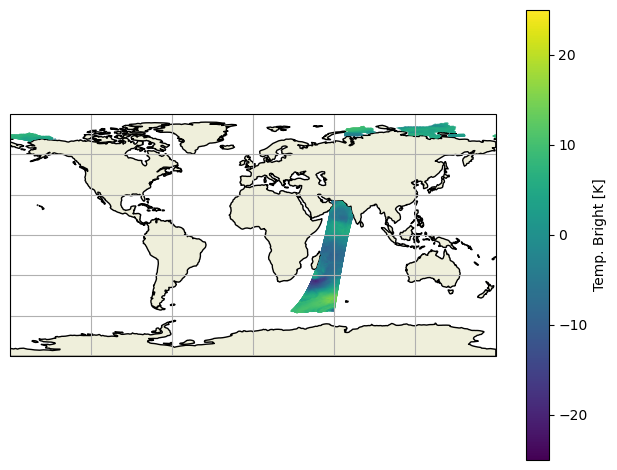

In [51]:
# Plot the resampled (Nearest neighb.) ECMWF data in the new 'grid' 
# (i.e. the satellite swath):

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
get_Sat_frame(work_SAT_ds, area_def_world, chan=3, 
              var = 'u10n_apriori_nn', begin_t=None, end_t=None)

basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'resampled', area_interest, vmin=-25, vmax=25)

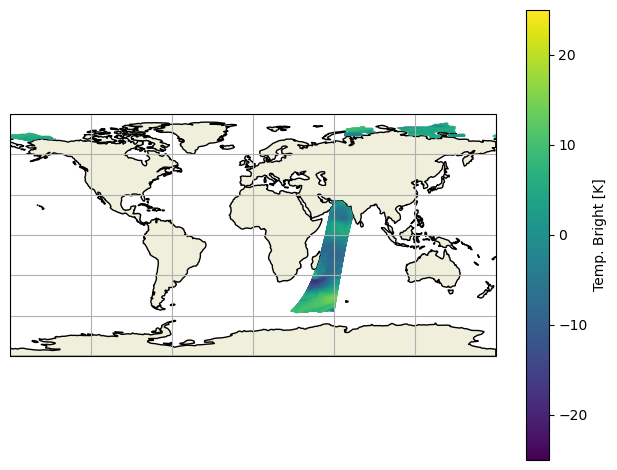

In [52]:
# Plot the resampled (Gaussian interp.) ECMWF data in the new 'grid' 
# (i.e. the satellite swath):

#reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
#get_Sat_frame(work_SAT_ds, area_def_world, var='dataGauss', begin_t=None, end_t=None)

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
get_Sat_frame(work_SAT_ds, area_def_world, chan=3, 
              var = 'u10n_apriori_gauss', begin_t=None, end_t=None)

basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'resampledGauss', area_interest, vmin=-25, vmax=25)

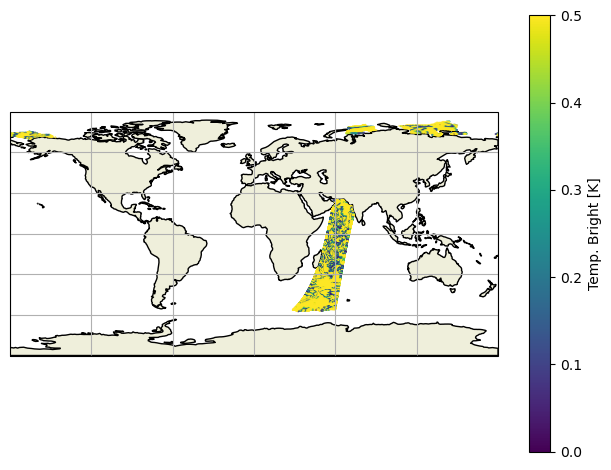

In [56]:
work_SAT_ds['differenceNN_GN'] = np.abs(work_SAT_ds['u10n_apriori_gauss'][:,:,0]-
                                        work_SAT_ds['u10n_apriori_gauss'][:,:,3])

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
get_Sat_frame(work_SAT_ds, area_def_world, chan=-1, 
              var = 'differenceNN_GN', begin_t=None, end_t=None)

basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'difference_NN_GN', area_interest, vmin=0, vmax=0.5)

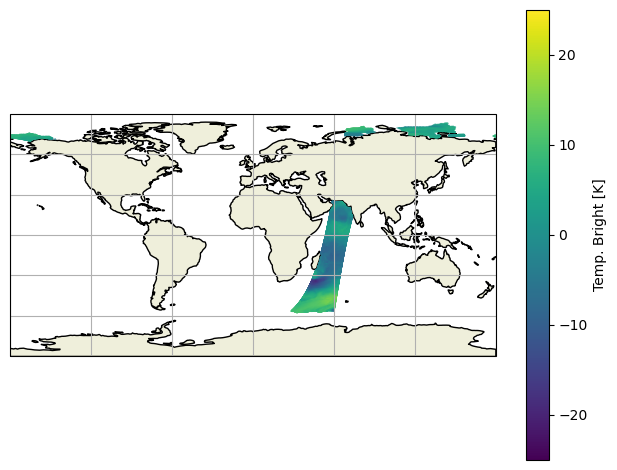

In [61]:
#work_SAT_ds['u10n_apriori_gauss_interp'] 

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
get_Sat_frame(work_SAT_ds, area_def_world, chan=-1, 
              var = 'u10n_apriori_gauss_interp', begin_t=None, end_t=None)

basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'spaceTimeInterpolated', area_interest, vmin=-25, vmax=25)

In [ ]:
# Plot origin data (ECMWF on regular grid, to compare with the resampled one):

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
work_ECMWF_ds.u10n[0,:,:].where(
    work_ECMWF_ds.lsm[0,:,:]==0).plot(ax=ax,
    transform=ccrs.PlateCarree(), cmap="viridis")
plt.tight_layout()
plt.savefig('allWind.png', bbox_inches='tight', dpi=300) 

In [ ]:
# Some histograms:

#ds_tb_log = np.log10(ds_work.tb[:,0,:]) 
#ds_work.tb[:,0,:].plot.hist(bins=20,)
#ds_tb_log.plot.hist(bins=30,)

In [ ]:
def bigHistogram(da, numbins=20):
    # Computing histogram of all the values contained in dataarray da:
    # We resort to this way of computing the histogram because
    # the normal xarray.plot.hist produced strange plots:

    datamin = np.nanmin(da.values)
    datamax = np.nanmax(da.values)
    #numbins = 20

    delta = (datamax-datamin)/numbins
    mybins =np.linspace(datamin+delta/2,
                    datamax-delta/2,
                    numbins) # Bins midpoint locations
    # Cycle in time:
    #hist, _ = np.histogram(da.isel(time=0).values.ravel(), bins = numbins,
    #                       range=(np.nanmin(da.isel(time=0)),np.nanmax(da.isel(time=0))))
    #for i in range(1, len(da["time"])):
    #    hist += np.histogram(da.isel(time=i).values.ravel(), bins = numbins,
    #                        range=(np.nanmin(da.isel(time=i)),np.nanmax(da.isel(time=i))))[0]

    hist, _ = np.histogram(da.isel(scene_across_track=0).values.ravel(), bins = numbins,
                       range=(np.nanmin(da.isel(scene_across_track=0)),
                              np.nanmax(da.isel(scene_across_track=0))))
    for i in range(1, len(da["scene_across_track"])):
        hist += np.histogram(da.isel(scene_across_track=i).values.ravel(), bins = numbins,
                        range=(np.nanmin(da.isel(scene_across_track=i)),
                               np.nanmax(da.isel(scene_across_track=i))))[0]
        print('Step '+str(i)+' of '+
             str(len(da["scene_across_track"]))+
             ' done!')
    
    return hist, mybins


In [ ]:
# channels: 
# 0 => 19 GHz, H
# 1 => 19 GHz, V
# 2 => 37 GHz, H
# 3 => 37 GHz, V

In [ ]:
da = SAT_ds.tb[:,3,:].dropna(
    dim='time', how='all').chunk(
    chunks={'time':45000})

numbins = 20
hist, bins = bigHistogram(da, numbins=numbins)

In [ ]:
# Plot histogram using seaborn:
plt.figure()
sns.histplot(x=bins, weights=hist, discrete=False, bins=numbins)
plt.xlabel('Temperature Brightness [K] ')
plt.grid(visible=True)
plt.title('Distribution of Temp. Brightness in channel 37V')
plt.savefig('hist_TB_channel37V.png',dpi =150) 

In [ ]:
da0 = SAT_ds.tb[:,0,:].dropna(
    dim='time', how='all').chunk(
    chunks={'time':45000})
da1 = SAT_ds.tb[:,3,:].dropna(
    dim='time', how='all').chunk(
    chunks={'time':45000})


In [ ]:
da0

In [ ]:
plt.figure()
plt.scatter(da0.stack(index=("time","scene_across_track")), 
           da1.stack(index=("time","scene_across_track")))
plt.xlabel('Temperature Brightness [K], 19H')
plt.ylabel('Temperature Brightness [K], 37V')
plt.grid(visible=True)
plt.title('Scatter plot 19H vs 37V')
#plt.show()
plt.savefig('scatter_19H_37V.png',dpi =150) 

In [ ]:
ds_tb = SAT_ds.tb[:,:,:].dropna(
    dim='time', how='all')
ds_tb

In [ ]:
nrows = SAT_ds.tb[:,:,:].stack(
    index=('time','scene_across_track'
          )).transpose("index", "scene_channel"
                      ).dropna(how='all', dim = 'index'
                   ).to_pandas().shape[0] #.to_csv('scores.csv')

newIndex = np.arange(nrows)

dataframe_TB = SAT_ds.tb[:,:,:].stack(
    index=('time','scene_across_track'
          )).transpose("index", "scene_channel"
                      ).dropna(how='all', dim = 'index'
                              ).to_pandas().set_index(
    keys=newIndex)
dataframe_TB.index.name = 'example'
dataframe_TB #.to_csv('eigenVal.csv')

In [ ]:
#dataframe_TB.to_csv('dataframe_TB.csv')
dataframe_TB = pd.read_csv('dataframe_TB.csv')
del dataframe_TB['example']
dataframe_TB.index.name = 'example'
dataframe_TB

In [ ]:
X_train, X_test = train_test_split(dataframe_TB, test_size=0.2, random_state=42)

In [ ]:
X_test, X_outliers = train_test_split(X_test, test_size=0.2, random_state=42)

In [ ]:
X_outliers.iloc[0:100000,:] = X_outliers.iloc[0:100000,:] + 3
X_outliers.iloc[100001:200000,:] = X_outliers.iloc[100001:200000,:] - 3
X_outliers.iloc[200001:300000,:] = X_outliers.iloc[200001:300000,:] + 5
X_outliers.iloc[300001:400000,:] = X_outliers.iloc[300001:400000,:] - 5
X_outliers.iloc[400001:500000,:] = X_outliers.iloc[400001:500000,:] + 10
X_outliers.iloc[500001:600000,:] = X_outliers.iloc[500001:600000,:] - 10
X_outliers.iloc[600001:645857,:] = X_outliers.iloc[600001:645857,:] + 15

In [ ]:
# fit the model

#clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1, verbose = 1)
#clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
#y_pred_test = clf.predict(X_test)
#y_pred_outliers = clf.predict(X_outliers)
#n_error_train = y_pred_train[y_pred_train == -1].size
#n_error_test = y_pred_test[y_pred_test == -1].size
#n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

nu = 0.05
gamma = 2.0
random_state = 42
# Fit the One-Class SVM using a kernel approximation and SGD
transform = Nystroem(gamma=gamma, random_state=random_state)
clf_sgd = SGDOneClassSVM(nu=nu, shuffle=True, 
                         fit_intercept=True, random_state=random_state, 
                         tol=1e-4, verbose = 1)

pipe_sgd = make_pipeline(transform, clf_sgd)
pipe_sgd.fit(X_train)
y_pred_train_sgd = pipe_sgd.predict(X_train)
y_pred_test_sgd = pipe_sgd.predict(X_test)
y_pred_outliers_sgd = pipe_sgd.predict(X_outliers)
n_error_train_sgd = y_pred_train_sgd[y_pred_train_sgd == -1].size
n_error_test_sgd = y_pred_test_sgd[y_pred_test_sgd == -1].size
n_error_outliers_sgd = y_pred_outliers_sgd[y_pred_outliers_sgd == 1].size

In [ ]:
def covariance(da):
    
    # Inputs:
    # da, xarray datarray
    
    # Outputs:
    # listMatrices, list of covariances to be shaped as a numpy 2D array.
    
    listMatrices = []
    #listIndices = []
    
    for channel1 in da.scene_channel:
        for channel2 in da.scene_channel:
        
            listMatrices.append(  # Compute the variance and append it to the list of variances.
                xr.cov( da.sel(scene_channel=channel1).stack(
                    index=('time','scene_across_track')).chunk(
                    chunks={'index':1000000}), 
                   da.sel(scene_channel=channel2).stack(
                    index=('time','scene_across_track')).chunk(
                    chunks={'index':1000000}), 
                       dim='index').compute().values
            ) 
            #print('Variable: '+str(channel1)+str(channel2)+', appended')          

    print("Computed variances: ")
    print(listMatrices)
    #print(listIndices)
    
    
    # Return the diagonal matrix of covariances and the names of the indices
    return listMatrices #np.diag(out), listIndices  

In [ ]:
# With xarray option 1 (only diagonal terms):

#ds_cov = xr.cov(ds_tb, ds_tb, dim = 'index')
#ds_cov

# With xarray option 2 (full matrix):
covList = covariance(ds_tb)
covList

covMatrix = np.asarray(covList).reshape((4,4))


In [ ]:
eigenVal, eigenVec = np.linalg.eig(covMatrix)

In [ ]:
eigVal_DataArray = xr.DataArray(data=np.diag(eigenVal), 
                                dims=['channel_latentSpace','channel_latentSpace_T'])
eigVal_DataArray

In [ ]:
cov_DataArray = xr.DataArray(data=covMatrix, 
                             dims=['scene_channel','scene_channel_T'])
cov_DataArray

In [ ]:
eigenVec_DataArray = xr.DataArray(data=eigenVec, 
                                  dims=['scene_channel','scene_channel_reduced'])
eigenVec_DataArray

In [ ]:
cov_DataArray.to_pandas().to_csv('covariance.csv')
eigenVec_DataArray.to_pandas().to_csv('eigenVec.csv')
eigVal_DataArray.to_pandas().to_csv('eigenVal.csv')

In [ ]:

#ds_T = ds_tb.stack(
#    index=('time','scene_across_track')).chunk(
#    chunks={'index':1000000}).dot(w_DataArray)
#ds_T

ds_T = xr.dot(ds_tb.stack(
    index=('time','scene_across_track')).chunk(
    chunks={'index':1000000}), 
              eigenVec_DataArray)
ds_T

In [ ]:
plt.figure()
plt.scatter(ds_T[:,0], 
           ds_T[:,1])
plt.xlabel('Scores_0 [Units]')
plt.ylabel('Scores_3 [Units]')
plt.grid(visible=True)
plt.title('Scatter plot Scores_0 vs Scores_3')
#plt.show()
plt.savefig('scatter_Scores_0_Scores_3.png',dpi =150) 

In [ ]:


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(ds_T[:,0], 
           ds_T[:,1], ds_T[:,2])

ax.set_xlabel('Scores_0 [Units]')
ax.set_ylabel('Scores_1 [Units]')
ax.set_zlabel('Scores_2 [Units]')

#plt.grid(visible=True)
#plt.title('Scatter plot Scores_0_1_2')
plt.show()

In [ ]:
nrows = ds_T.dropna(how='all', dim = 'index').to_pandas().shape[0] #.to_csv('scores.csv')
newIndex = np.arange(nrows)

dataframe_scores = ds_T.dropna(how='all', dim = 'index'
                              ).to_pandas().set_index(
    keys=newIndex)
dataframe_scores.index.name = 'example'
dataframe_scores #.to_csv('eigenVal.csv')

In [ ]:
dataframe_scores.to_csv('scores.csv')

In [ ]:
#scores = pd.read_csv('scores.csv')
#scores
dataframe_scores.iloc[:,0]

In [ ]:
# Plot histogram using seaborn:
plt.figure()
sns.histplot(data = dataframe_scores.iloc[:,0], bins=20)
plt.xlabel('Score_0')
plt.grid(visible=True)
plt.title('Distribution of Score 0')
plt.savefig('hist_Score0.png',dpi =150) 

In [ ]:
plt.figure()
sns.jointplot(dataframe_scores.iloc[:,0:2], x = 0, y = 1)
plt.xlabel('Score_0')
plt.ylabel('Score_1')
plt.grid(visible=True)
plt.title('Distribution of Score 0 and 1')
plt.savefig('JoinPlot_Score0_1.png',dpi =150) 

In [ ]:
plt.figure()
sns.displot(dataframe_scores.iloc[:,0:2], x = 0, y = 1)
plt.xlabel('Score_0')
plt.ylabel('Score_1')
plt.grid(visible=True)
plt.title('Distribution of Score 0 and 1')
plt.savefig('hist2D_Score0_1.png',dpi =150) 

In [ ]:
scores = pd.read_csv('scores.csv')

In [ ]:
scores